## Retail Store Sales Forecasting with Neural Networks -
## ARMA, ARIMA, Seasonal ARIMA , and Auto-ARIMA method
## By Yasaman Ensafi - 500913843
### Ryerson Data Science and Analytics (MSc)
#### 2019

## Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
import seaborn as sns
from statsmodels.graphics import tsaplots
import statsmodels.api as sm
from pylab import rcParams
import itertools
import warnings
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import sys

## Load Dataset

In [2]:
data= pd.read_excel('Sample_Superstore.xls')

## Edit columns names

In [3]:
# Lower case column names
data.columns = map(str.lower, data.columns)

#Replace spaces with '_'
data.columns = data.columns.str.replace(" ", "_")
data.columns = data.columns.str.replace("-", "_")
data.columns

Index(['row_id', 'order_id', 'order_date', 'ship_date', 'ship_mode',
       'customer_id', 'customer_name', 'segment', 'country', 'city', 'state',
       'postal_code', 'region', 'product_id', 'category', 'sub_category',
       'product_name', 'sales', 'quantity', 'discount', 'profit'],
      dtype='object')

## Separate dataframe of each category

In [4]:
furniture=data.loc[data['category'] == 'Furniture']

technology=data.loc[data['category'] == 'Technology']
office=data.loc[data['category'] == 'Office Supplies']

## Aggregating sales data by date

In [5]:
furniture= furniture.groupby('order_date')['sales'].sum().reset_index()

technology= technology.groupby('order_date')['sales'].sum().reset_index()
office= office.groupby('order_date')['sales'].sum().reset_index()

In [6]:
#Set index 
furniture = furniture.set_index('order_date')

technology = technology.set_index('order_date')
office = office.set_index('order_date')

In [7]:
#furniture['sales']

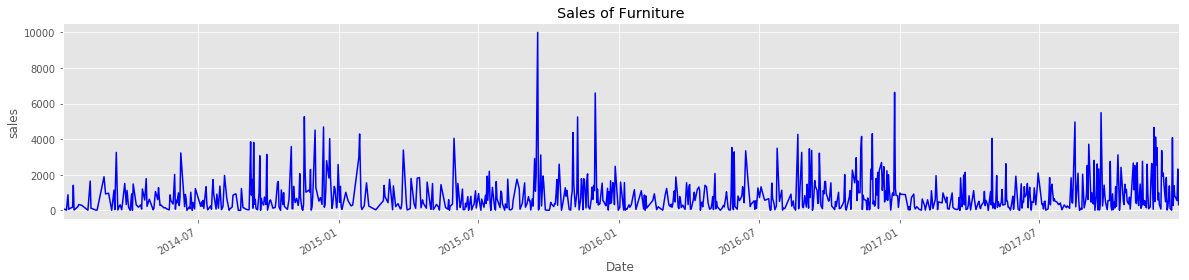

In [8]:
ax= furniture['sales'].plot(color='blue',figsize=(20,4))
ax.set_xlabel("Date")
ax.set_ylabel('sales')
ax.set_title("Sales of Furniture")
plt.show()

In [9]:
#Resampling the data on monthly frequency
# Using averages daily sales value - set start of the month as index
df = furniture['sales'].resample('MS').mean()
#df= df.to_frame() 

#avg_technology_sales = technology_sales['sales'].resample('MS').mean()
#avg_office_sales = office_sales['sales'].resample('MS').mean()

In [11]:
df.head(n=5)

order_date
2014-01-01    480.194231
2014-02-01    367.931600
2014-03-01    857.291529
2014-04-01    567.488357
2014-05-01    432.049187
Freq: MS, Name: sales, dtype: float64

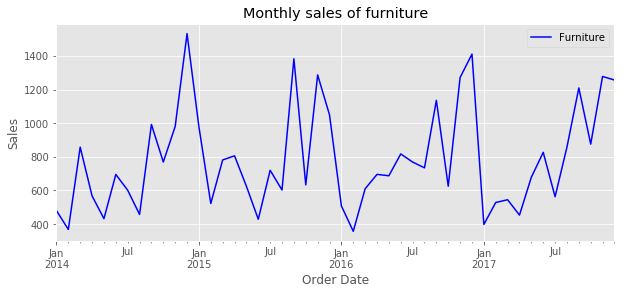

In [12]:
df.plot(figsize=(10, 4),color='blue',label = 'Furniture')

#avg_technology_sales.plot(figsize=(10, 4),color='red',label = 'Technology')

#avg_office_sales.plot(figsize=(10, 4),color='green',label = 'Office Supplies')
plt.xlabel("Order Date")
plt.ylabel('Sales')
plt.title("Monthly sales of furniture")
plt.legend()
plt.show()

## Seasonal decomposition:

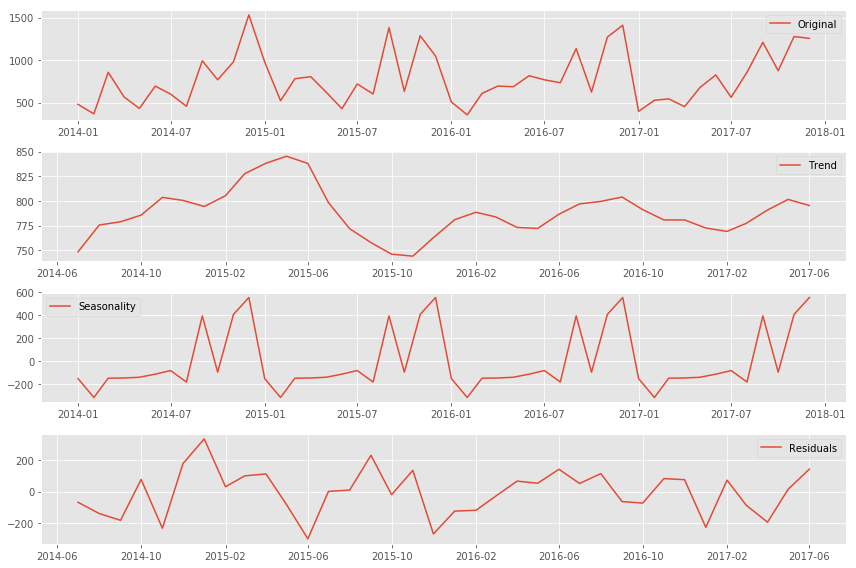

In [13]:
#Furniture time-series decomposition
decomposition = seasonal_decompose(df,freq=12)
rcParams['figure.figsize'] = 12, 8

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(df, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [14]:
def test_stationarity(timeseries):
    rcParams['figure.figsize'] = 10, 6
    rolmean = timeseries.rolling(12).mean() #allows you to calculate moving avg
    rolstd = timeseries.rolling(12).std() 
    
    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    print('p-value=', dftest[1])

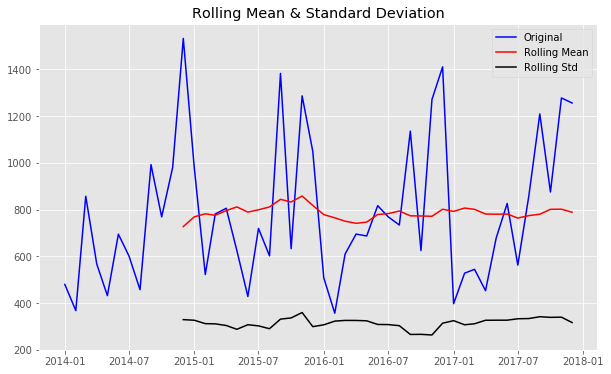

Results of Dickey-Fuller Test:
p-value= 9.168756655665942e-06


In [15]:
#check to see if the time-series is stationary or non-stationary
test_stationarity(df)
#p-value= 9.168756655665942e-06

### Train and test split

In [13]:
X = df
train_size = int(len(X) * 0.75)
trainset, testset= X[0:train_size], X[train_size:]

### Measure of prediction accuracy

In [40]:
def performance(y_true, y_pred): 
    #y_true, y_pred = np.array(y_true), np.array(y_pred)
    mse = ((y_pred - y_true) ** 2).mean()
    mape= np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return( print(' The MSE of forecasts is {}'.format(round(mse, 2))+
                  '\n The RMSE of forecasts is {}'.format(round(np.sqrt(mse), 2))+
                  '\n The MAPE of forecasts is {}'.format(round(mape, 2))))

## ARMA model

In [54]:
from statsmodels.tsa.arima_model import ARMA
model_arma = ARMA(trainset, order = (1,1))
model_arma_fit = model_arma.fit(disp=False)
arma_predict = model_arma_fit.predict(start=pd.to_datetime('2017-01-01'), end=pd.to_datetime('2017-12-01')
                                           ,dynamic=False)

/Users/yas/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:336: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)


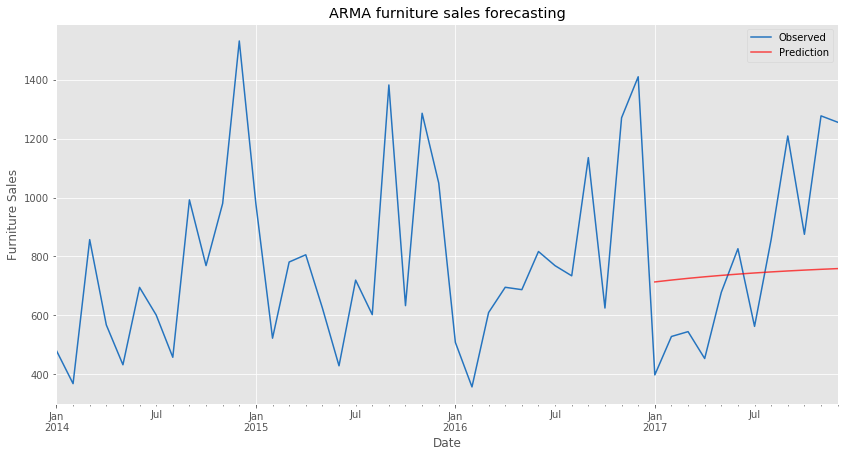

In [55]:
# One step ahead forecast
#observed plot
ax = df.plot(label='Observed',color='#2574BF')
#predicted plot
rcParams['figure.figsize'] = 14, 7
arma_predict.plot(ax=ax, label='Prediction', alpha= 0.7, color='red') 
plt.title('ARMA furniture sales forecasting')
plt.xlabel('Date')
plt.ylabel('Furniture Sales')
plt.legend()
plt.show()



In [56]:
performance(testset,arma_predict)

 The MSE of forecasts is 87237.01
 The RMSE of forecasts is 295.36
 The MAPE of forecasts is 33.88


## ARIMA model

In [60]:
from statsmodels.tsa.arima_model import ARIMA
model_arima = ARIMA(trainset, order = (1,1,1))
model_arima_fit = model_arima.fit(disp=False)
arima_predict = model_arima_fit.predict(start=pd.to_datetime('2017-01-01'), end=pd.to_datetime('2017-12-01')
                                           ,dynamic=False)

/Users/yas/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:336: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)
/Users/yas/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:320: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)


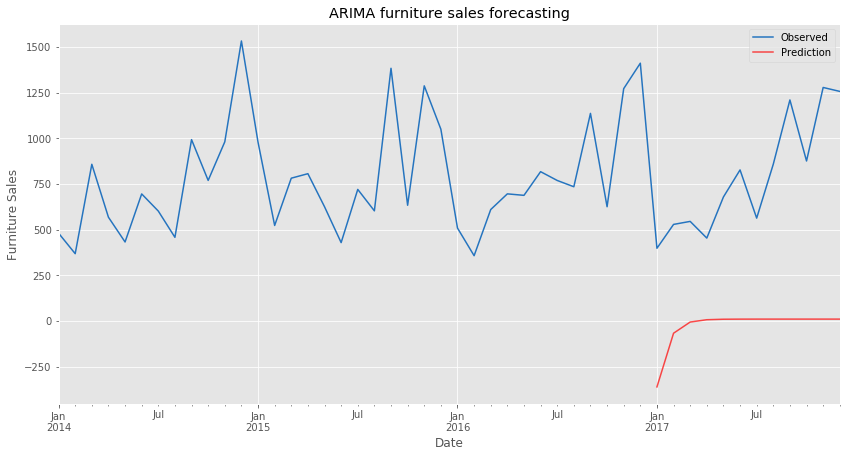

In [61]:
# One step ahead forecast
#observed plot
ax = df.plot(label='Observed',color='#2574BF')
#predicted plot
rcParams['figure.figsize'] = 14, 7
arima_predict.plot(ax=ax, label='Prediction', alpha= 0.7, color='red') 
plt.title('ARIMA furniture sales forecasting')
plt.xlabel('Date')
plt.ylabel('Furniture Sales')
plt.legend()
plt.show()

In [62]:
performance(testset,arima_predict)

 The MSE of forecasts is 743686.99
 The RMSE of forecasts is 862.37
 The MAPE of forecasts is 107.88


## ACF plot

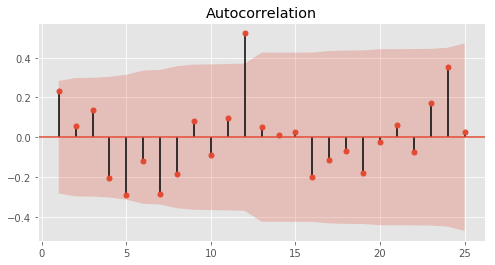

In [12]:
from statsmodels.graphics.tsaplots import plot_acf
fig,ax = plt.subplots(1,1,figsize=(8,4))
plot_acf(df,ax=ax,zero=False,lags=25)
plt.show()

#From the peaks we can see that the frequency is 12

## Seasonal ARIMA model

### Find optimal order - Develop a Grid Search Framework

In [24]:
## method 1
import pmdarima as pm
model = pm.auto_arima(trainset,seasonal=True, m=12,d=0, D=1, max_p=2, max_q=2,
                       trace=True,error_action='ignore',suppress_warnings=True) 

# Print model summary
print(model.summary())

#best model is Fit ARIMA: order=(0, 0, 0) seasonal_order=(1, 1, 0, 12); AIC=329.940,

Fit ARIMA: order=(2, 0, 2) seasonal_order=(1, 1, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 1, 0, 12); AIC=338.682, BIC=341.038, Fit time=0.035 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 1, 0, 12); AIC=331.614, BIC=336.327, Fit time=0.287 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 1, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(0, 1, 0, 12); AIC=340.006, BIC=343.540, Fit time=0.099 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(2, 1, 0, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 1, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(2, 1, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(1, 1, 0, 12); AIC=329.940, BIC=333.474, Fit time=0.228 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(1, 1, 0, 12); AIC=331.653, BIC=336.366, Fit time=0.28

In [25]:
# Define the p, d and q parameters to take a value between 0 and 2
p = d = q = range(0, 2)

# Generate different combinations of p, d and q
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [19]:
#method 2

warnings.filterwarnings("ignore")
lowest_aic = sys.maxsize
lowest = ''

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(trainset,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            
            print('SARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
            
            if lowest_aic >  results.aic:
                lowest = 'SARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic)
                lowest_aic = results.aic
        except:
            continue

print ("The lowes AIC belongs to "+lowest)



SARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:573.2736548047211
SARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:320.39031701172337
SARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:339.13659906594717
SARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:158.31115188193314
SARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:535.956097491259
SARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:308.98276881122155
SARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:340.55729582954075
SARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:158.06483656135666
SARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:501.6523533373235
SARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:319.3351634712986
SARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:330.687098693596
SARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:145.77300556718512
SARIMA(0, 1, 1)x(0, 0, 0, 12)12 - AIC:477.6653149075071
SARIMA(0, 1, 1)x(0, 1, 0, 12)12 - AIC:299.4712944291711
SARIMA(0, 1, 1)x(1, 0, 0, 12)12 - AIC:327.5605738441135
SARIMA(0, 1, 1)x(1, 1, 0, 12)12 - AIC:147.21230738075826
SARIMA(1, 0, 0)x(0, 0, 0, 12)12 - AIC:516.6922617187157
SARIMA(1, 0, 0)x(0, 1, 0, 12)12 - AIC:321.

### Fitting the model

In [26]:
#fitting model
#order=(10, 0, 2),seasonal_order=(1, 1, 1, 1) -> mape 26
sarima_model = sm.tsa.statespace.SARIMAX(trainset,
                                order=(0, 0, 0),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
sarima_fit = sarima_model.fit()
print(sarima_fit.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.6292      0.176     -3.570      0.000      -0.975      -0.284
sigma2       2.25e+04   1.57e+04      1.429      0.153   -8356.220    5.34e+04


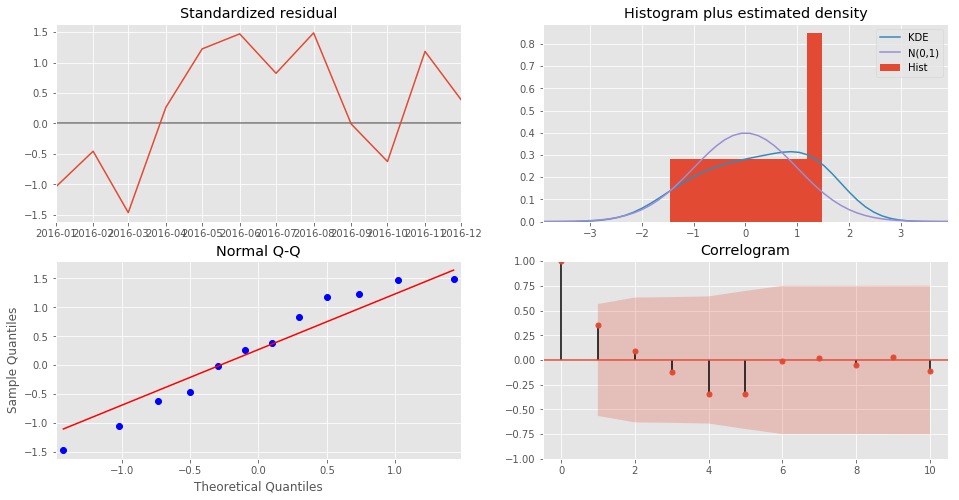

In [21]:
sarima_fit.plot_diagnostics(figsize=(16, 8))
plt.show()

### Validating forecasts

/Users/yas/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:336: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)


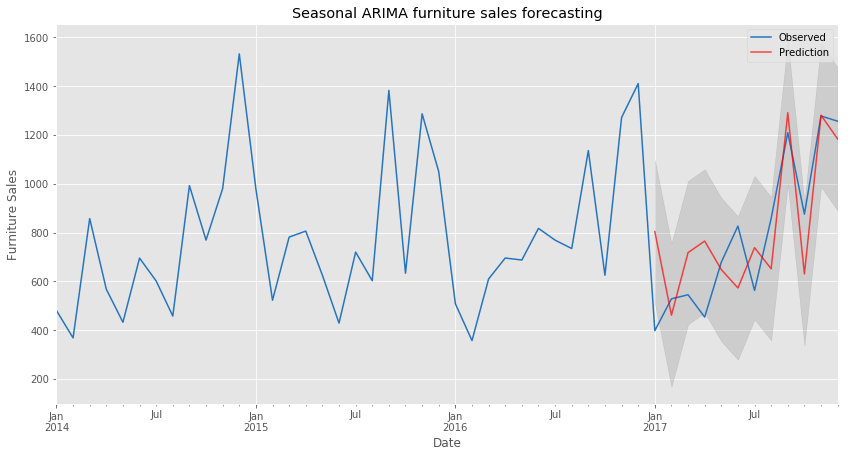

In [28]:
# One step ahead forecast
sarima_predict = sarima_fit.get_prediction(start=pd.to_datetime('2017-01-01'), end=pd.to_datetime('2017-12-01')
                                           ,dynamic=False)
sarima_predict_conf = sarima_predict.conf_int()
#observed plot
ax = df.plot(label='Observed',color='#2574BF')
#predicted plot
rcParams['figure.figsize'] = 14, 7
sarima_predict.predicted_mean.plot(ax=ax, label='Prediction', alpha= 0.7, color='red') 
ax.fill_between(sarima_predict_conf.index,
                #lower sales
                sarima_predict_conf.iloc[:, 0],
                #upper sales
                sarima_predict_conf.iloc[:, 1], color='k', alpha=0.1)
plt.title('Seasonal ARIMA furniture sales forecasting')
plt.xlabel('Date')
plt.ylabel('Furniture Sales')
plt.legend()
plt.show()


In [24]:
performance(testset,sarima_predict.predicted_mean)

 The MSE of forecasts is 42305.37
 The RMSE of forecasts is 205.68
 The MAPE of forecasts is 28.89


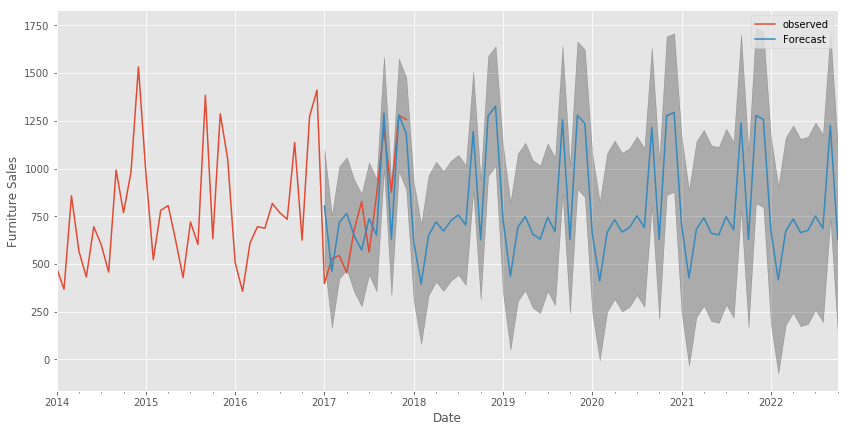

In [25]:
furthur_predict = sarima_fit.get_forecast(steps=70)
furthur_conf = furthur_predict.conf_int()
ax = df.plot(label='observed', figsize=(14, 7))
furthur_predict.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(furthur_conf.index,
                furthur_conf.iloc[:, 0],
                furthur_conf.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()

## Auto-ARIMA

In [26]:
#using auto-ARIMA that reported back the best AIC value.
#building the model
from pmdarima.arima import auto_arima
model2 = auto_arima(trainset, trace=True, error_action='ignore', suppress_warnings=True,seasonal=True,m=12,D=1)
results2=model2.fit(trainset)

forecast = model2.predict(n_periods=len(testset))
forecast = pd.DataFrame(forecast,index = testset.index,columns=['Prediction'])

Fit ARIMA: order=(2, 0, 2) seasonal_order=(1, 1, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 1, 0, 12); AIC=338.682, BIC=341.038, Fit time=0.016 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 1, 0, 12); AIC=331.614, BIC=336.327, Fit time=0.261 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 1, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(0, 1, 0, 12); AIC=340.006, BIC=343.540, Fit time=0.077 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(2, 1, 0, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 1, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(2, 1, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(1, 1, 0, 12); AIC=329.940, BIC=333.474, Fit time=0.209 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(1, 1, 0, 12); AIC=331.653, BIC=336.366, Fit time=0.29

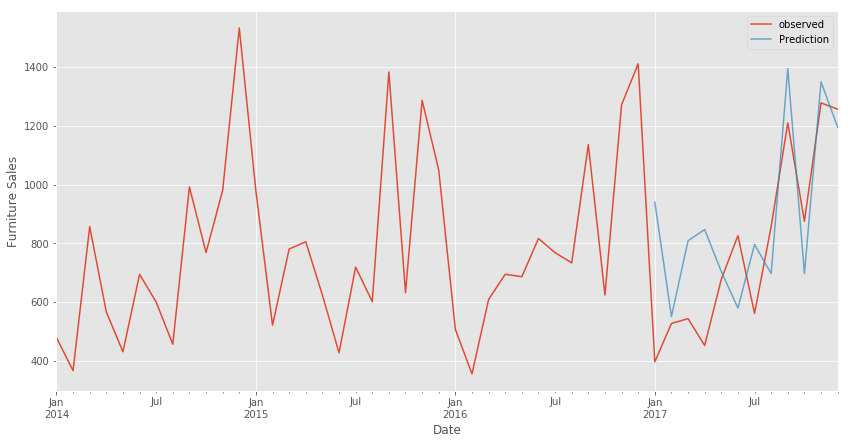

In [27]:
# One step ahead forecast
yhat2 = forecast
#yhat_conf2 = yhat2.conf_int()
#observed plot
ax = df['2014':].plot(label='observed')
#predicted plot
yhat2.plot(ax=ax, label='One step ahead forecast', alpha=.7, figsize=(14, 7))
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()



In [28]:
performance(testset,forecast['Prediction'])

 The MSE of forecasts is 61362.37
 The RMSE of forecasts is 247.71
 The MAPE of forecasts is 34.7
